In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from scipy.optimize import minimize

# Classification

## Lecture des données

In [2]:
def lecture_fichier(nom_fichier):
    """Lit les fichiers train et test du TP."""
    donnees = []
    
    with open(f"data/{nom_fichier}") as fichier:
        for ligne in fichier:
            a, b, c = ligne.split()
            a = float(a)
            b = float(b)
            c = int(c.replace('"', ""))
            
            donnees.append([a, b, int(c)])
    
    return np.array(donnees)

In [3]:
trainA = lecture_fichier("trainA")
trainB = lecture_fichier("trainB")
trainC = lecture_fichier("trainC")

testA = lecture_fichier("testA")
testB = lecture_fichier("testB")
testC = lecture_fichier("testC")

In [4]:
print(f"{trainA.shape = }")
print(f"{trainB.shape = }")
print(f"{trainC.shape = }")

print(f"{testA.shape = }")
print(f"{testB.shape = }")
print(f"{testC.shape = }")

trainA.shape = (100, 3)
trainB.shape = (200, 3)
trainC.shape = (300, 3)
testA.shape = (100, 3)
testB.shape = (200, 3)
testC.shape = (300, 3)


In [5]:
input_size = trainA.shape[1]

## Analyse Linéaire Discriminante

## Régression Logistique

### Implémentation

#### Fonctionnelle

In [166]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [167]:
def log_vraisemblance(beta, x, y):
    somme = 0
    
    for i in range(len(x)):
        somme += y[i] * np.log(sigmoid(np.dot(x[i], beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], beta)))

    return -somme

In [168]:
beta_initial = np.zeros(x.shape[1])

result = minimize(log_vraisemblance, beta_initial, args=(x, y))#, method='TNC')

optimal_beta = result.x
print("Paramètres optimaux (beta) :", optimal_beta)

Paramètres optimaux (beta) : [  6.76134417 -11.39109915]


#### Classe

In [169]:
class RegressionLogistique:
    def __init__(self):
        self.beta = None

    def log_vraisemblance(self, x, y):
        somme = 0
        
        for i in range(len(x)):
            somme += y[i] * np.log(sigmoid(np.dot(x[i], self.beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], self.beta)))
    
        return -somme

    def optimise(self, beta_initial, x, y):
        result = minimize(self.log_vraisemblance, beta_initial, args=(x, y))
        beta_optimal = result.x
        return beta_optimal

    def fit(self, x_train, y_train):
        beta_initial = np.zeros(x_train.shape[1] + 1)
        x_train_avec_biais = np.hstack(
            (
                np.ones((x_train.shape[0], 1)),
                x_train
            )
        )

        beta_optimal = self.optimise(beta_initial, x_train, y_train)
        self.beta = beta_optimal

        

In [170]:
from functools import partial
from scipy.optimize import minimize
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class RegressionLogistique:
    def __init__(self):
        self.beta = None

    def log_vraisemblance(self, beta, x, y):
        somme = 0
        
        for i in range(len(x)):
            somme += y[i] * np.log(sigmoid(np.dot(x[i], beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], beta)))
    
        return -somme

    def optimise(self, beta_initial, x, y):
        log_vraisemblance_partial = partial(self.log_vraisemblance, x=x, y=y)
        result = minimize(log_vraisemblance_partial, beta_initial)
        beta_optimal = result.x
        return beta_optimal

    def rajoute_biais(self, x):
        return np.hstack(
            (
                np.ones((x.shape[0], 1)),
                x
            )
        )

    def fit(self, x_train, y_train):
        beta_initial = np.zeros(x_train.shape[1] + 1)
        x_train_avec_biais = self.rajoute_biais(x_train)

        beta_optimal = self.optimise(beta_initial, x_train_avec_biais, y_train)
        self.beta = beta_optimal

    def predict(self, x_test):
        x_test_avec_biais = self.rajoute_biais(x_test)
        
        return sigmoid(np.dot(x_test_avec_biais, self.beta))

### Application au jeu de données

In [171]:
rl = RegressionLogistique()

In [172]:
x_train = trainA[:, :2]
y_train = trainA[:, 2:]

x_test = testA[:, :2]
y_test = testA[:, 2:]

In [173]:
rl.fit(x_train, y_train)

/tmp/ipykernel_3449/2226731614.py:16: RuntimeWarning: divide by zero encountered in log
  somme += y[i] * np.log(sigmoid(np.dot(x[i], beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], beta)))
/tmp/ipykernel_3449/2226731614.py:16: RuntimeWarning: invalid value encountered in multiply
  somme += y[i] * np.log(sigmoid(np.dot(x[i], beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], beta)))
/tmp/ipykernel_3449/2226731614.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_3449/2226731614.py:16: RuntimeWarning: divide by zero encountered in log
  somme += y[i] * np.log(sigmoid(np.dot(x[i], beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], beta)))
/tmp/ipykernel_3449/2226731614.py:16: RuntimeWarning: invalid value encountered in multiply
  somme += y[i] * np.log(sigmoid(np.dot(x[i], beta))) + (1 - y[i]) * np.log(1 - sigmoid(np.dot(x[i], beta)))
/tmp/ipykernel_3449/2226731614.py:6: RuntimeWarning: overflow encountered in exp
  return 1 /

In [174]:
rl.beta

array([ 3074.63004759,   748.48375466, -1288.20106211])

In [175]:
y_pred_train = rl.predict(x_train)

/tmp/ipykernel_3449/2226731614.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [176]:
y_pred_test = rl.predict(x_test)

/tmp/ipykernel_3449/2226731614.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


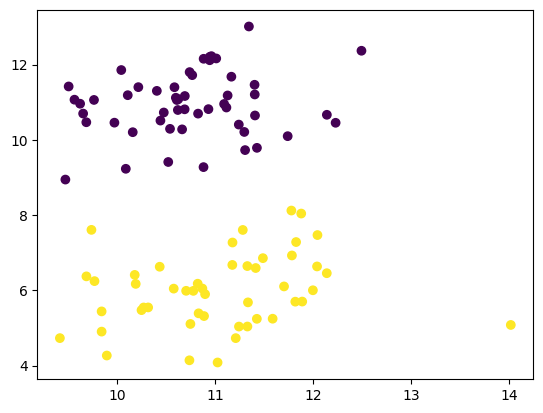

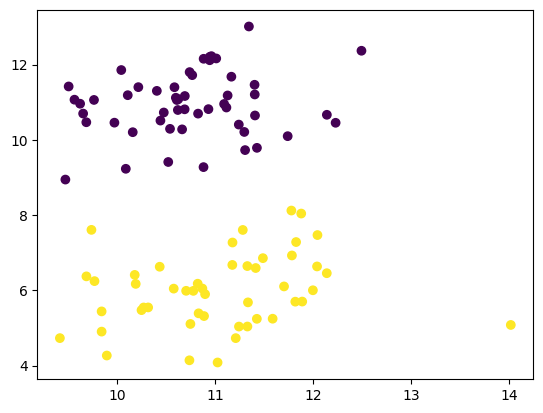

In [177]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.show()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred_train)

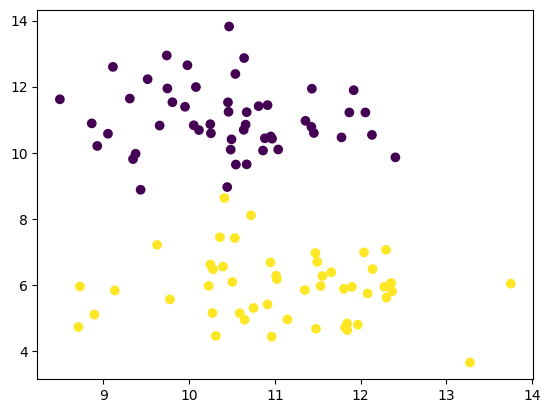

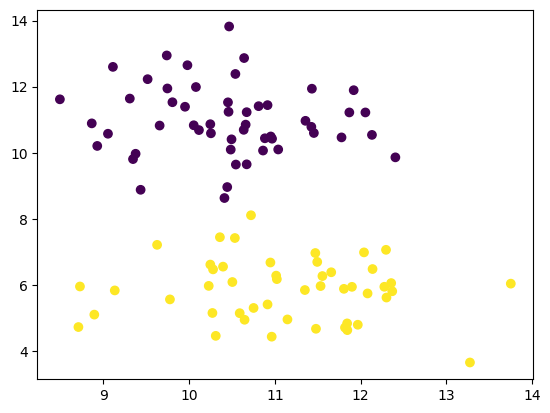

In [178]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.show()
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred_test)

#### Mini-jeu de test (à enlever)

In [94]:
beta = [0, 0, 0]
x = [
    [2, 3],
    [1, 3],
    [2, 0],
    [2, 0],
]
y = [0, 0, 1, 1]

In [8]:
# ajout du biais
for i in range(len(x)):
    x[i] = [1] + x[i]

In [98]:
beta = np.array(beta)
x = np.array(x)
y = np.array(y)

In [10]:
print(f"{x.shape = }")
print(f"{y.shape = }")

x.shape = (4, 3)
y.shape = (4,)


## Régression linéaire

## Réseau de neurones

In [13]:
class Classifieur(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        # couche d'entrée
        self.layer1 = nn.Linear(input_size, 9)

        # couches cachées
        self.layer2 = nn.Linear(9, 8)
        self.layer3 = nn.Linear(8, 7)
        self.layer4 = nn.Linear(7, 6)
        self.layer5 = nn.Linear(6, 5)

        # couche de sortie
        self.layer6 = nn.Linear(5, 1)

        # fonction d'activation    
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.sigmoid(x)
        return x

In [14]:
input_data = torch.randn(32, input_size)
model = Classifieur(input_size=3)

In [15]:
output = model(input_data)
print(output.size())

torch.Size([32, 1])


## Application

# Modèle de mélange gaussien

## Lecture des données

In [16]:
decathlon = pd.read_csv("data/decathlon.csv")

In [17]:
decathlon.shape

(41, 11)

In [18]:
decathlon.head()

,Unnamed: 0,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
0,SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7
1,CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5
2,KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2
3,BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1
4,YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4


In [19]:
new_columns = list(decathlon.columns)

In [20]:
new_columns[0] = "name"

In [21]:
decathlon.columns = new_columns

In [22]:
decathlon.head()

,name,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
0,SEBRLE,11.04,7.58,14.83,2.07,49.81,14.69,43.75,5.02,63.19,291.7
1,CLAY,10.76,7.40,14.26,1.86,49.37,14.05,50.72,4.92,60.15,301.5
2,KARPOV,11.02,7.30,14.77,2.04,48.37,14.09,48.95,4.92,50.31,300.2
3,BERNARD,11.02,7.23,14.25,1.92,48.93,14.99,40.87,5.32,62.77,280.1
4,YURKOV,11.34,7.09,15.19,2.10,50.42,15.31,46.26,4.72,63.44,276.4


In [23]:
decathlon["name"].nunique()

41

In [24]:
decathlon.drop(columns=["name"], inplace=True)

In [25]:
from sklearn.mixture import GaussianMixture

In [26]:
liste_aic = []
liste_bic = []

n_min = 1
n_min = 1
n_max = 10

for n in range(n_min, n_max + 1):
    gmm = GaussianMixture(covariance_type="full", n_components=n, init_params="kmeans", n_init=100)
    gmm.fit(decathlon)
    liste_aic.append(gmm.aic(decathlon))
    liste_bic.append(gmm.bic(decathlon))

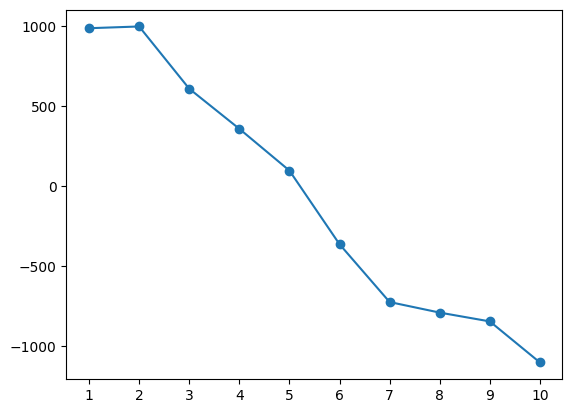

In [27]:
plt.plot(range(n_min, n_max + 1), liste_aic, "o-")
plt.xticks(range(n_min, n_max + 1))
plt.show()

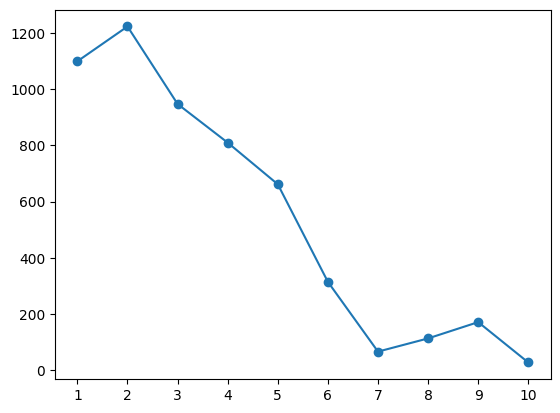

In [28]:
plt.plot(range(n_min, n_max + 1), liste_bic, "o-")
plt.xticks(range(n_min, n_max + 1))
plt.show()

### K = 3 clusters

In [29]:
gmm = GaussianMixture(covariance_type="full", n_components=3, init_params="k-means++", n_init=1_000)

In [30]:
gmm.fit(decathlon)

GaussianMixture(init_params='k-means++', n_components=3, n_init=1000)

In [31]:
gmm.predict(decathlon)

array([1, 1, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1])

In [32]:
gmm.aic(decathlon)

479.96030736887315

In [33]:
gmm.bic(decathlon)

817.5340045096218

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=2)

In [36]:
pca.fit(decathlon)

PCA(n_components=2)

In [37]:
pca.explained_variance_ratio_

array([0.7965959 , 0.13552956])

In [38]:
0.79 + 0.13

0.92

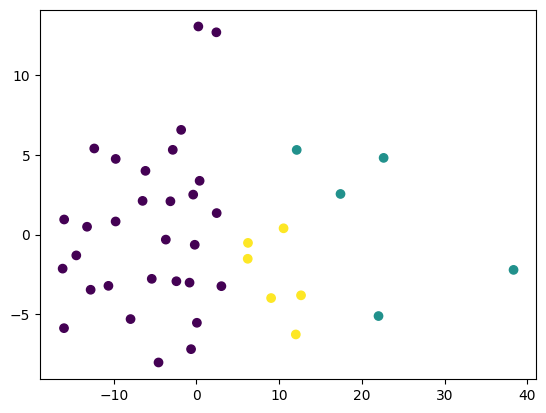

In [39]:
plt.scatter(*pca.transform(decathlon).T, c=gmm.predict(decathlon))

In [40]:
gmm.weights_

array([0.73170732, 0.12195122, 0.14634146])

In [41]:
gmm.means_

array([[ 10.979     ,   7.29333333,  14.48233333,   1.97733333,
         49.27233333,  14.56533333,  43.97533333,   4.73133333,
         59.13366667, 273.45333333],
       [ 11.008     ,   7.206     ,  14.718     ,   1.97      ,
         50.382     ,  14.636     ,  47.63      ,   4.792     ,
         57.064     , 301.304     ],
       [ 11.085     ,   7.13833333,  14.25      ,   1.98      ,
         50.69833333,  14.78333333,  43.32333333,   4.89333333,
         55.275     , 288.31666667]])

- parler des proportions/tailles des clusters
- parler des centres des clusters

In [42]:
mu = pd.DataFrame(gmm.means_)
mu.columns = decathlon.columns

In [43]:
mu

,100m,Long.jump,Shot.put,High.jump,400m,110m.hurdle,Discus,Pole.vault,Javeline,1500m
0,10.979,7.293333,14.482333,1.977333,49.272333,14.565333,43.975333,4.731333,59.133667,273.453333
1,11.008,7.206000,14.718000,1.970000,50.382000,14.636000,47.630000,4.792000,57.064000,301.304000
2,11.085,7.138333,14.250000,1.980000,50.698333,14.783333,43.323333,4.893333,55.275000,288.316667


Clusters avec les plus forts :
- 100m (min) 1
- saut longueur (min) 0
- lancer de poids max
- saut en hauteur max
- 400m min
- 110m haies min
- disque max
- saut perche max
- javelot max
- 1500m min

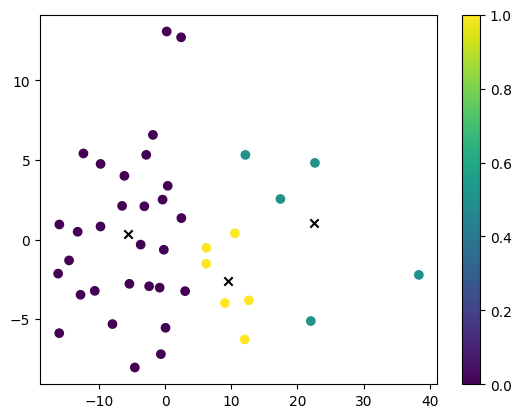

In [44]:
plt.scatter(*pca.transform(decathlon).T, c=gmm.predict(decathlon))
plt.scatter(*pca.transform(mu).T, marker="x", color="black")
plt.colorbar()